# 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import random
import numpy as np
import copy
import matplotlib.pyplot as plt

# 2. Model Information

In [2]:
class SimpleMLP(nn.Module):
  def __init__(self, input_dim=28*28, h1=256, h2=128, num_classes=10):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, num_classes)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# 3. Functions

In [3]:
def random_walk_masks(model, num_paths=100, device="cpu"):
  """
  perform biased random walks from output to input

  starts from random output neuron, then sample a previous neuron based on |W[row]|

  returns:
  masks in the same order as [fc1, fc2, fc3] weights
  """

  # walk over fc3, fc2, fc1 and then reverse at the end
  layers = [model.fc3, model.fc2, model.fc1]
  layer_weights = [l.weight.detach().abs().to(device) for l in layers]

  # initialize masks for each weight
  rw_masks = [torch.zeros_like(w, device=device) for w in layer_weights]

  # keep track of which rows are visisted
  rows_visited = [torch.zeros(w.size(0), device=device) for w in layer_weights]

  # first layer in the output dim
  out_dim = layer_weights[0].size(0)

  for _ in range(num_paths):
    # start from a random output neuron
    i = random.randint(0, out_dim-1)

    # walk from output layer back to input
    for layer_idx, W in enumerate(layer_weights):
      row = W[i]

      # if row is all zeroes pick uniform
      if torch.all(row == 0):
        probs = torch.ones_like(row)/row.numel()
      else:
        probs = row / (row.sum() + 1e-8)

      # sample neuron j
      j = torch.multinomial(probs, 1).item()

      # mark this edge
      rw_masks[layer_idx][i, j] = 1.0

      # mark that row i was visited
      rows_visited[layer_idx][i] = 1.0

      # for next layer in walk, neuron j becomes our row index
      i = j

  # reverse mask and row-visited lists to match [fc1, fc2, fc3]
  rw_masks.reverse()
  rows_visited.reverse()

  return rw_masks, rows_visited





In [4]:
def random_walk_masks_from_labels(model, labels, num_paths=100, device="cpu"):
    """
    Perform biased random walks from output → input, but
    start each walk at the output neuron for a *real label* in the batch.

    labels: 1D tensor of shape [batch_size], with class indices.
    """

    # We'll walk over [fc3, fc2, fc1] and then reverse at the end
    layers = [model.fc3, model.fc2, model.fc1]
    layer_weights = [l.weight.detach().abs().to(device) for l in layers]

    # Initialize masks for each weight matrix
    rw_masks = [torch.zeros_like(w, device=device) for w in layer_weights]
    rows_visited = [torch.zeros(w.size(0), device=device) for w in layer_weights]

    # Output layer dim (number of classes)
    out_dim = layer_weights[0].size(0)

    for _ in range(num_paths):
        # Pick a random example in the batch
        b = random.randint(0, labels.size(0) - 1)
        # Start at its true class neuron
        i = labels[b].item()   # integer in [0, out_dim-1]

        # Safety check: just in case label is out of range
        i = max(0, min(i, out_dim - 1))

        # Walk from output layer (fc3) back to input (via fc2, fc1)
        for layer_idx, W in enumerate(layer_weights):
            row = W[i]  # outgoing weights from neuron i to previous layer

            if torch.all(row == 0):
                probs = torch.ones_like(row) / row.numel()
            else:
                probs = row / (row.sum() + 1e-8)

            j = torch.multinomial(probs, num_samples=1).item()

            # mark edge i→j
            rw_masks[layer_idx][i, j] = 1.0
            rows_visited[layer_idx][i] = 1.0

            # move to previous layer neuron index
            i = j

    # Reverse to match [fc1, fc2, fc3]
    rw_masks.reverse()
    rows_visited.reverse()

    return rw_masks, rows_visited


In [5]:
def mask_density(rw_masks):
    """
    Compute global fraction of weights that are updated
    given a list of masks (one per layer).
    """
    total_ones = 0
    total_elems = 0
    for m in rw_masks:
        total_ones += m.sum().item()
        total_elems += m.numel()
    return total_ones / total_elems if total_elems > 0 else 0.0


In [6]:
def grad_density(model):
    """
    Count how many parameters have non-zero gradients.

    Returns:
      nonzero (int): number of parameters with grad != 0
      total (int): total number of parameters that have gradients
      density (float): nonzero / total
    """
    total = 0
    nonzero = 0

    for p in model.parameters():
        if p.grad is None:
            continue
        numel = p.numel()
        total += numel
        nonzero += (p.grad != 0).sum().item()

    density = nonzero / total if total > 0 else 0.0
    return nonzero, total, density


In [7]:
def apply_random_walk_mask(model, rw_masks, row_visits):
  """
  Multiply gradients by random-walk masks (for weights)
  and restrict bias grads to visited rows

  """
  fc_layers = [model.fc1, model.fc2, model.fc3]

  for layer, mask, rows in zip(fc_layers, rw_masks, row_visits):
    if layer.weight.grad is not None:
      layer.weight.grad *= mask

    if layer.bias is not None and layer.bias.grad is not None:
      # keep bais gradient only for neurons whose row was visited
      layer.bias.grad *= rows



## Training Loops

In [8]:
def train_epoch(model, loader, optimizer, device, mode="full", num_paths=100):
    """
    mode:
      - "full"       : full backprop (baseline)
      - "rw_random"  : random-walk starting from random output neuron
      - "rw_target"  : random-walk starting from true label neuron
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0



    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()   # compute full grads first

        if mode == "rw_random":
            rw_masks, row_visits = random_walk_masks(
                model, num_paths=num_paths, device=device
            )
            apply_random_walk_mask(model, rw_masks, row_visits)

        elif mode == "rw_target":
            rw_masks, row_visits = random_walk_masks_from_labels(
                model, y, num_paths=num_paths, device=device
            )
            apply_random_walk_mask(model, rw_masks, row_visits)

        # if mode == "full", do nothing special with grads


        # update weights

        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


In [9]:
def train_epoch_density(model, loader, optimizer, device, mode="full", num_paths=100):
    """
    mode:
      - "full"       : full backprop (baseline)
      - "rw_random"  : random-walk starting from random output neuron
      - "rw_target"  : random-walk starting from true label neuron
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    density_sum = 0.0
    density_count = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()   # compute full grads first

        if mode == "rw_random":
            rw_masks, row_visits = random_walk_masks(
                model, num_paths=num_paths, device=device
            )
            apply_random_walk_mask(model, rw_masks, row_visits)

        elif mode == "rw_target":
            rw_masks, row_visits = random_walk_masks_from_labels(
                model, y, num_paths=num_paths, device=device
            )
            apply_random_walk_mask(model, rw_masks, row_visits)

        # if mode == "full", do nothing special with grads

        # measure grad density sparsity after masking or full
        nonzero, total_params, density = grad_density(model)
        density_sum += density
        density_count += 1

        # update weights

        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    avg_density = density_sum / max(density_count, 1)
    return avg_loss, acc, avg_density


In [10]:
def eval_epoch(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


# 5. Test 1

Comparing the Three Algorithms Running Training Loops

In [11]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using device", device)



using device cpu


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [13]:
# base model to define initial weights
base_model = SimpleMLP().to(device)
base_state = copy.deepcopy(base_model.state_dict())

In [14]:
# 1) full backprop
full_model_1 = SimpleMLP().to(device)
full_model_1.load_state_dict(copy.deepcopy(base_state))
full_opt_1 = optim.Adam(full_model_1.parameters(), lr=1e-3)

# 2) random-walk from random output neuron
rw_random_model_1 = SimpleMLP().to(device)
rw_random_model_1.load_state_dict(copy.deepcopy(base_state))
rw_random_opt_1 = optim.Adam(rw_random_model_1.parameters(), lr=1e-3)

# 3) random-walk from target class
rw_target_model_1 = SimpleMLP().to(device)
rw_target_model_1.load_state_dict(copy.deepcopy(base_state))
rw_target_opt_1 = optim.Adam(rw_target_model_1.parameters(), lr=1e-3)

In [15]:
num_epochs = 5
num_paths_per_batch = 10

hist_full = {"train_acc": [], "test_acc": []}
hist_rw_random = {"train_acc": [], "test_acc": []}
hist_rw_target = {"train_acc": [], "test_acc": []}

# 5.1 training full backprop

In [16]:
print("\n=== Training: FULL BACKPROP ===")
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(
        full_model_1, train_loader, full_opt_1, device,
        mode="full"
    )
    test_loss, test_acc = eval_epoch(full_model_1, test_loader, device)
    hist_full["train_acc"].append(train_acc)
    hist_full["test_acc"].append(test_acc)

    print(f"[FULL] Epoch {epoch}: "
          f"Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")



=== Training: FULL BACKPROP ===
[FULL] Epoch 1: Train loss 0.2677, acc 0.9223 | Test loss 0.1419, acc 0.9525
[FULL] Epoch 2: Train loss 0.1053, acc 0.9677 | Test loss 0.0839, acc 0.9732
[FULL] Epoch 3: Train loss 0.0699, acc 0.9785 | Test loss 0.0772, acc 0.9764
[FULL] Epoch 4: Train loss 0.0501, acc 0.9845 | Test loss 0.0748, acc 0.9783
[FULL] Epoch 5: Train loss 0.0397, acc 0.9868 | Test loss 0.0810, acc 0.9754


## 5.2 training random-walks

In [17]:
print("\n=== Training: RANDOM-WALK (RANDOM OUTPUT) ===")
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(
        rw_random_model_1, train_loader, rw_random_opt_1, device,
        mode="rw_random", num_paths=num_paths_per_batch
    )
    test_loss, test_acc = eval_epoch(rw_random_model_1, test_loader, device)
    hist_rw_random["train_acc"].append(train_acc)
    hist_rw_random["test_acc"].append(test_acc)

    print(f"[RW-RANDOM] Epoch {epoch}: "
          f"Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")




=== Training: RANDOM-WALK (RANDOM OUTPUT) ===
[RW-RANDOM] Epoch 1: Train loss 2.2308, acc 0.3111 | Test loss 2.0955, acc 0.5615
[RW-RANDOM] Epoch 2: Train loss 1.8469, acc 0.6458 | Test loss 1.5264, acc 0.7205
[RW-RANDOM] Epoch 3: Train loss 1.2409, acc 0.7503 | Test loss 0.9627, acc 0.7981
[RW-RANDOM] Epoch 4: Train loss 0.8226, acc 0.8127 | Test loss 0.6753, acc 0.8370
[RW-RANDOM] Epoch 5: Train loss 0.6207, acc 0.8431 | Test loss 0.5418, acc 0.8553


In [18]:
print("\n=== Training: RANDOM-WALK (TARGET OUTPUT) ===")
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(
        rw_target_model_1, train_loader, rw_target_opt_1, device,
        mode="rw_target", num_paths=num_paths_per_batch
    )
    test_loss, test_acc = eval_epoch(rw_target_model_1, test_loader, device)
    hist_rw_target["train_acc"].append(train_acc)
    hist_rw_target["test_acc"].append(test_acc)

    print(f"[RW-TARGET] Epoch {epoch}: "
          f"Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")


=== Training: RANDOM-WALK (TARGET OUTPUT) ===
[RW-TARGET] Epoch 1: Train loss 2.2259, acc 0.3278 | Test loss 2.0833, acc 0.5786
[RW-TARGET] Epoch 2: Train loss 1.8310, acc 0.6401 | Test loss 1.5062, acc 0.7139
[RW-TARGET] Epoch 3: Train loss 1.2260, acc 0.7478 | Test loss 0.9453, acc 0.7930
[RW-TARGET] Epoch 4: Train loss 0.8127, acc 0.8083 | Test loss 0.6659, acc 0.8331
[RW-TARGET] Epoch 5: Train loss 0.6191, acc 0.8403 | Test loss 0.5435, acc 0.8565


In [19]:
print("\nFinal test accuracies (by epoch):")
print("FULL      :", hist_full["test_acc"])
print("RW-RANDOM :", hist_rw_random["test_acc"])
print("RW-TARGET :", hist_rw_target["test_acc"])


Final test accuracies (by epoch):
FULL      : [0.9525, 0.9732, 0.9764, 0.9783, 0.9754]
RW-RANDOM : [0.5615, 0.7205, 0.7981, 0.837, 0.8553]
RW-TARGET : [0.5786, 0.7139, 0.793, 0.8331, 0.8565]


## 5.3 Graphing Results

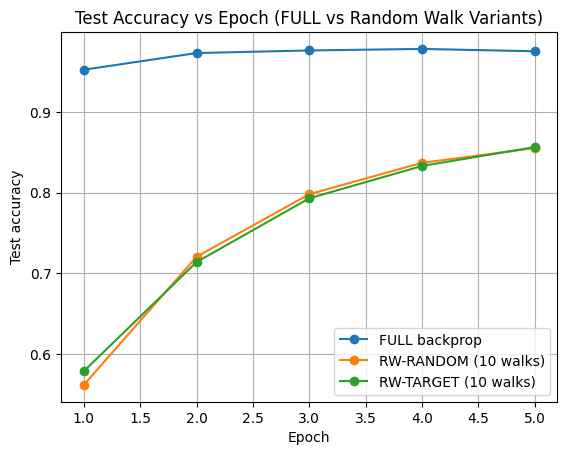

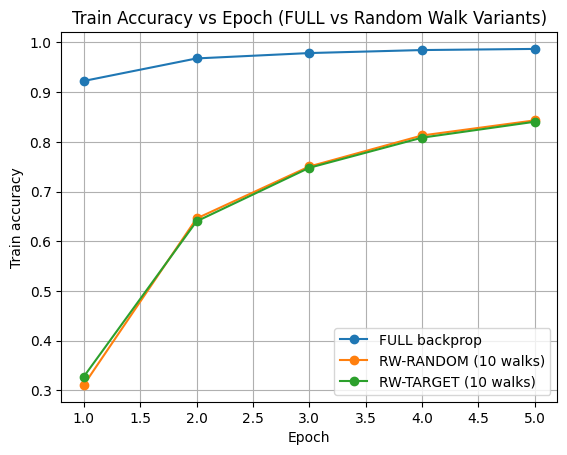

In [20]:
epochs = range(1, num_epochs + 1)

# Test accuracy curves
plt.figure()
plt.plot(epochs, hist_full["test_acc"],      marker="o", label="FULL backprop")
plt.plot(epochs, hist_rw_random["test_acc"], marker="o", label="RW-RANDOM (10 walks)")
plt.plot(epochs, hist_rw_target["test_acc"], marker="o", label="RW-TARGET (10 walks)")
plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.title("Test Accuracy vs Epoch (FULL vs Random Walk Variants)")
plt.legend()
plt.grid(True)
plt.show()

# (Optional) Training accuracy curves
plt.figure()
plt.plot(epochs, hist_full["train_acc"],      marker="o", label="FULL backprop")
plt.plot(epochs, hist_rw_random["train_acc"], marker="o", label="RW-RANDOM (10 walks)")
plt.plot(epochs, hist_rw_target["train_acc"], marker="o", label="RW-TARGET (10 walks)")
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.title("Train Accuracy vs Epoch (FULL vs Random Walk Variants)")
plt.legend()
plt.grid(True)
plt.show()

# 6. Test 2: Paths and Desnity

## Setup

In [21]:
import copy

paths_list = [10, 50, 200, 500, 1000]
num_epochs_2 = 5
rw_target_results = {}  # key: num_paths, value: history dict

# keeping track of full backprop progress
hist_full_density = {"train_acc":[], "test_acc":[], "density":[]}



## 6.1 Training full backprop
keeping track of number of nodes being updated and accuracy

In [22]:
# defining model
full_model_2 = SimpleMLP().to(device)
full_model_2.load_state_dict(copy.deepcopy(base_state))
full_opt_2 = optim.Adam(full_model_2.parameters(), lr=1e-3)

# training full backprop
print("Test 2: Full Backprop (density and accuracy)")
for epoch in range(1, num_epochs_2+1):
  train_loss, train_acc, train_density = train_epoch_density(
      full_model_2, train_loader, full_opt_2, device, mode="full"
  )

  test_loss, test_acc = eval_epoch(full_model_2, test_loader, device)

  hist_full_density["train_acc"].append(train_acc)
  hist_full_density["test_acc"].append(test_acc)
  hist_full_density["density"].append(train_density)

  print(f"[FULL | Epoch {epoch}] "
          f"Train loss {train_loss:.4f}, acc {train_acc:.4f}, "
          f"density {train_density:.4f} | "
          f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")

Test 2: Full Backprop (density and accuracy)
[FULL | Epoch 1] Train loss 0.2762, acc 0.9184, density 0.9412 | Test loss 0.1269, acc 0.9631
[FULL | Epoch 2] Train loss 0.1048, acc 0.9677, density 0.9504 | Test loss 0.0931, acc 0.9702
[FULL | Epoch 3] Train loss 0.0689, acc 0.9784, density 0.9499 | Test loss 0.0898, acc 0.9728
[FULL | Epoch 4] Train loss 0.0513, acc 0.9839, density 0.9515 | Test loss 0.0717, acc 0.9780
[FULL | Epoch 5] Train loss 0.0404, acc 0.9877, density 0.9504 | Test loss 0.0708, acc 0.9791


## 6.2 Training Random Walk Algorithms
keeping track of number of nodes being updated and accuracy

In [23]:
rw_target_density_results = {}
rw_random_density_results = {}

for num_paths in paths_list:
    print(f"\n=== Test 2: RW-TARGET with num_paths={num_paths} ===")

    # fresh model for this paths setting
    model_t = SimpleMLP().to(device)
    model_t.load_state_dict(copy.deepcopy(base_state))
    opt_t = optim.Adam(model_t.parameters(), lr=1e-3)

    history_t = {"train_acc": [], "test_acc": [], "density": []}

    for epoch in range(1, num_epochs_2 + 1):
        train_loss, train_acc, train_density = train_epoch_density(
            model_t, train_loader, opt_t, device,
            mode="rw_target", num_paths=num_paths
        )
        test_loss, test_acc = eval_epoch(model_t, test_loader, device)

        history_t["train_acc"].append(train_acc)
        history_t["test_acc"].append(test_acc)
        history_t["density"].append(train_density)

        print(f"[RW-TARGET | paths={num_paths} | epoch={epoch}] "
              f"Train loss {train_loss:.4f}, acc {train_acc:.4f}, "
              f"density {train_density:.6f} | "
              f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")

    rw_target_density_results[num_paths] = history_t

    # ---- RW-RANDOM (optional, comment out if you only care about rw_target) ----
    print(f"\n=== Test 2: RW-RANDOM with num_paths={num_paths} ===")

    model_r = SimpleMLP().to(device)
    model_r.load_state_dict(copy.deepcopy(base_state))
    opt_r = optim.Adam(model_r.parameters(), lr=1e-3)

    history_r = {"train_acc": [], "test_acc": [], "density": []}

    for epoch in range(1, num_epochs_2 + 1):
        train_loss, train_acc, train_density = train_epoch_density(
            model_r, train_loader, opt_r, device,
            mode="rw_random", num_paths=num_paths
        )
        test_loss, test_acc = eval_epoch(model_r, test_loader, device)

        history_r["train_acc"].append(train_acc)
        history_r["test_acc"].append(test_acc)
        history_r["density"].append(train_density)

        print(f"[RW-RANDOM | paths={num_paths} | epoch={epoch}] "
              f"Train loss {train_loss:.4f}, acc {train_acc:.4f}, "
              f"density {train_density:.6f} | "
              f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")

    rw_random_density_results[num_paths] = history_r


=== Test 2: RW-TARGET with num_paths=10 ===
[RW-TARGET | paths=10 | epoch=1] Train loss 2.2263, acc 0.3153, density 0.000235 | Test loss 2.0795, acc 0.5645
[RW-TARGET | paths=10 | epoch=2] Train loss 1.8148, acc 0.6501, density 0.000235 | Test loss 1.4835, acc 0.7322
[RW-TARGET | paths=10 | epoch=3] Train loss 1.2096, acc 0.7607, density 0.000235 | Test loss 0.9413, acc 0.8071
[RW-TARGET | paths=10 | epoch=4] Train loss 0.8113, acc 0.8176, density 0.000235 | Test loss 0.6713, acc 0.8384
[RW-TARGET | paths=10 | epoch=5] Train loss 0.6189, acc 0.8433, density 0.000235 | Test loss 0.5399, acc 0.8556

=== Test 2: RW-RANDOM with num_paths=10 ===
[RW-RANDOM | paths=10 | epoch=1] Train loss 2.2263, acc 0.3309, density 0.000236 | Test loss 2.0900, acc 0.5904
[RW-RANDOM | paths=10 | epoch=2] Train loss 1.8447, acc 0.6556, density 0.000234 | Test loss 1.5269, acc 0.7229
[RW-RANDOM | paths=10 | epoch=3] Train loss 1.2445, acc 0.7524, density 0.000236 | Test loss 0.9663, acc 0.7929
[RW-RANDOM | p

## 6.3 Graphing Results

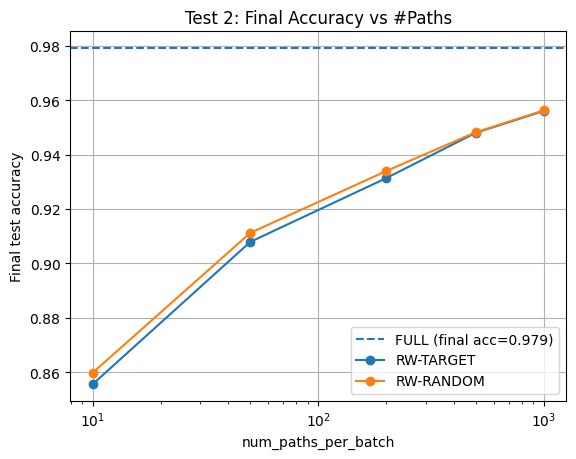

In [24]:
plt.figure()
final_full_acc = hist_full_density["test_acc"][-1]
plt.axhline(final_full_acc, linestyle="--", label=f"FULL (final acc={final_full_acc:.3f})")

final_rw_target_accs = [rw_target_density_results[p]["test_acc"][-1] for p in paths_list]
plt.plot(paths_list, final_rw_target_accs, marker="o", label="RW-TARGET")

final_rw_random_accs = [rw_random_density_results[p]["test_acc"][-1] for p in paths_list]
plt.plot(paths_list, final_rw_random_accs, marker="o", label="RW-RANDOM")

plt.xscale("log")
plt.xlabel("num_paths_per_batch")
plt.ylabel("Final test accuracy")
plt.title("Test 2: Final Accuracy vs #Paths")
plt.legend()
plt.grid(True)
plt.show()

Total Trainable Parameters 235146


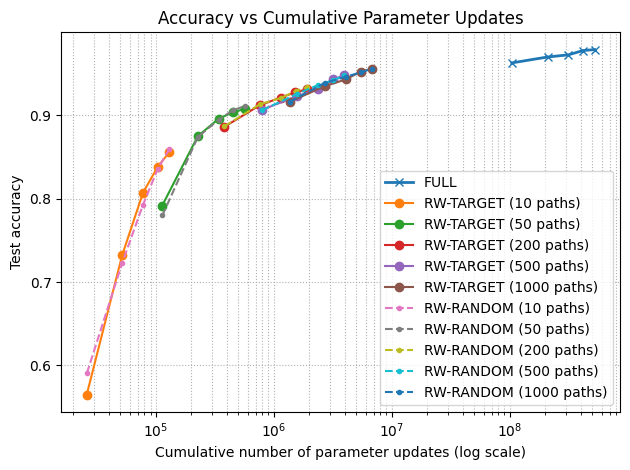

In [25]:
# total trainable parameters (you already print this, but reuse here)
total_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
print("Total Trainable Parameters", total_params)
batches_per_epoch = len(train_loader)

def cumulative_updates_from_densities(density_list):
    """
    Convert a list of per-epoch densities into a cumulative
    number of parameter-update operations.
    """
    per_epoch_updates = [
        d * total_params * batches_per_epoch for d in density_list
    ]
    return np.cumsum(per_epoch_updates)

plt.figure()

# ---- FULL backprop ----
full_cum = cumulative_updates_from_densities(hist_full_density["density"])
full_acc = hist_full_density["test_acc"]
plt.plot(
    full_cum, full_acc, marker="x", linestyle="-", linewidth=2,
    label="FULL"
)

# ---- RW-TARGET runs ----
for num_paths in paths_list:
    dens = rw_target_density_results[num_paths]["density"]
    accs = rw_target_density_results[num_paths]["test_acc"]
    cum = cumulative_updates_from_densities(dens)
    plt.plot(
        cum, accs, marker="o", linestyle="-",
        label=f"RW-TARGET ({num_paths} paths)"
    )

# ---- RW-RANDOM runs ----
for num_paths in paths_list:
    dens = rw_random_density_results[num_paths]["density"]
    accs = rw_random_density_results[num_paths]["test_acc"]
    cum = cumulative_updates_from_densities(dens)
    plt.plot(
        cum, accs, marker=".", linestyle="--",
        label=f"RW-RANDOM ({num_paths} paths)"
    )

plt.xscale("log")  # cumulative updates span orders of magnitude
plt.xlabel("Cumulative number of parameter updates (log scale)")
plt.ylabel("Test accuracy")
plt.title("Accuracy vs Cumulative Parameter Updates")
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()